In [57]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


In [58]:

def preprocess(sample, img_size):
    """Preprocessa le immagini: ridimensionamento e normalizzazione."""
    image = tf.image.resize(sample['image'], img_size) / 255.0  # Normalizza in [0,1]
    label = sample['label']  # Estrai l'etichetta
    return image, label

def load_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    dataset = tfds.load('oxford_iiit_pet', split=split, as_supervised=False)  # as_supervised=False per mantenere dict
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))  # Preprocessing
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Ottimizza il caricamento
    return dataset



In [59]:
# Parametri
img_size = (112, 112)
batch_size = 20
noise_factor = 0.4
epochs = 50

# Caricamento dataset
train_ds = load_dataset(split='train', img_size=img_size, batch_size=batch_size)
test_ds  = load_dataset(split='test', img_size=img_size, batch_size=batch_size)

In [60]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return x_noisy

In [61]:
train_ds_noisy = train_ds.map(lambda x, label: (add_noise(x, noise_factor), x))
test_ds_noisy  = test_ds.map(lambda x, label: (add_noise(x, noise_factor), x))

In [62]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

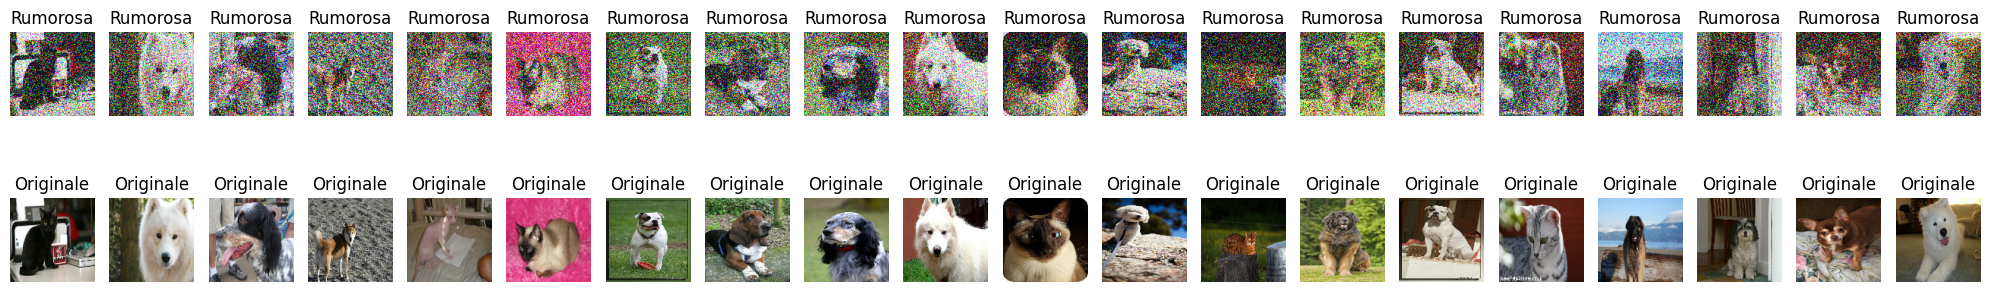

In [63]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(test_ds_noisy))
x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)


Creazione modello

In [64]:
def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [65]:
def pnsr(original, denoised):
  mse = np.mean((original - denoised) ** 2)
  if mse == 0:
    return float('inf') # immagini identiche
  max_pixel = 1.0 # valore massimo per immagini normalizzate in [0, 1]
  return 10 * np.log10((max_pixel ** 2) / mse)

In [66]:
def build_autoencoder(input_shape):
    """
    Costruisce un autoencoder convoluzionale per immagini a colori.
    Parametri:
      input_shape: forma dell'immagine in input (es. (32,32,3))
    Ritorna:
      autoencoder: modello compilato
    """
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder

def train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, epochs=50, batch_size=128):
    """
    Addestra l'autoencoder utilizzando le immagini rumorose come input e quelle originali come target.
    """
    history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test))
    return history

In [67]:
autoencoder = build_autoencoder(input_shape=(img_size[0], img_size[1], 3))
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 112, 112, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,307 (446.51 KB)

 Trainable params: 114,307 (446.51 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
history = autoencoder.fit(train_ds_noisy,
                validation_data=test_ds_noisy,
                batch_size=128,
                epochs=50)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.7278 - loss: 0.5357 - val_accuracy: 0.7411 - val_loss: 0.5321
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.7303 - loss: 0.5377 - val_accuracy: 0.7368 - val_loss: 0.5320
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.7294 - loss: 0.5370 - val_accuracy: 0.7300 - val_loss: 0.5321
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 31s 161ms/step - accuracy: 0.7293 - loss: 0.5388 - val_accuracy: 0.7423 - val_loss: 0.5319
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.7291 - loss: 0.5366 - val_accuracy: 0.7439 - val_loss: 0.5319
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.7322 - loss: 0.5380 - val_accuracy: 0.7070 - val_loss: 0.5321
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - accuracy: 0.7222 - loss: 0.5359 - val_accuracy: 0.7407 - val_loss: 0.5319
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.7300 - loss: 0.

In [82]:
decoded_imgs = autoencoder.predict(x_noisy_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


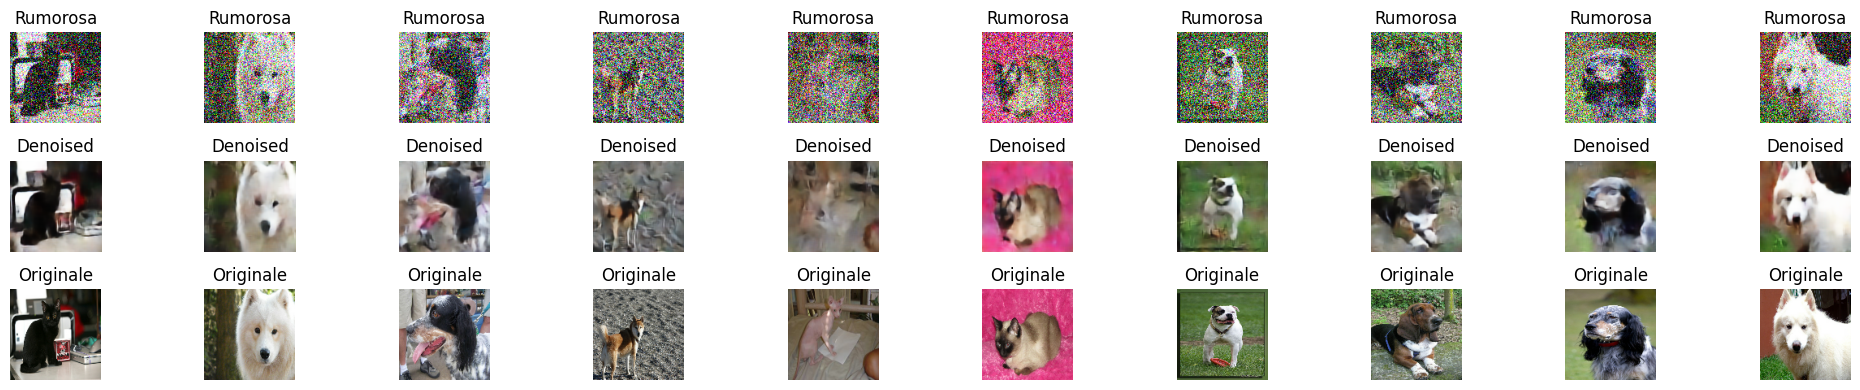

In [83]:
plot_denoising_results(x_noisy_np, decoded_imgs, x_original_np, n=10)

In [84]:
def psnr_batch(originals, denoiseds, max_pixel = 1.0):
  """
  Calcola il PSNR per ogni coppia di immagini in due batch.

  originals: np.array di shape (N, H, W, C)
  denoised: np.array di shape (N, H, W, C)
  max_pixel: valore massimo del pixel (1.0 se normalizzato, 255 per uint8)
  Ritorna:
  - lista dei PSNR (uno per immagine)
  """
  assert originals.shape == denoiseds.shape, "Shape mismatch!"
  psnrs = []
  for i in range(originals.shape[0]):
      mse = np.mean((originals[i] - denoiseds[i]) ** 2)
      if mse == 0:
          psnrs.append(float('inf'))
      else:
          psnrs.append(10 * np.log10((max_pixel ** 2) / mse))

  return psnrs



def plot_psnr(psnr_set1, psnr_set2, psnr_set3 = [], title="PSNR per immagine"):
    """
    psnr_set1: lista o lista di liste con PSNR dei denoised (es. per livello di rumore)
    psnr_set2: idem per le immagini noisy
    """
    noise_levels = [i for i in range(5, 5 * (len(psnr_set1) + 1), 5)]

    # Assicura che ogni set sia lista di liste (es. una lista per livello)
    psnr_set1 = [np.atleast_1d(p) for p in psnr_set1]
    psnr_set2 = [np.atleast_1d(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        psnr_set3 = [np.atleast_1d(p) for p in psnr_set3]

    # Figura
    plt.figure(figsize=(10, 6) )

    # Scatter di tutti i valori
    for i, level in enumerate(noise_levels):
        plt.scatter([level]*len(psnr_set1[i]), psnr_set1[i], marker='^', s=50, c='green', alpha=0.6)
        plt.scatter([level]*len(psnr_set2[i]), psnr_set2[i], marker='o', s=50, c='red', alpha=0.4)
        if(len(psnr_set3) > 0):
          plt.scatter([level]*len(psnr_set3[i]), psnr_set3[i], marker='x', s=50, c='blue', alpha=0.4)

    # Media PSNR per livello
    avg_psnr1 = [np.mean(p) for p in psnr_set1]
    avg_psnr2 = [np.mean(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        avg_psnr3 = [np.mean(p) for p in psnr_set3]

    # Linea media
    plt.plot(noise_levels, avg_psnr1, color='green', label='Media PSNR - Denoised', linewidth=2)
    plt.plot(noise_levels, avg_psnr2, color='red', label='Media PSNR - Noisy', linewidth=2)
    if(len(psnr_set3) > 0):
        plt.plot(noise_levels, avg_psnr3, color='blue', label='Media PSNR - Noisy +', linewidth=2)

    plt.xlabel('Noise Level')
    plt.ylabel('PSNR (dB)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [85]:
print(history.history.keys())  # mostra le chiavi disponibili


dict_keys([])


In [91]:
print(history.history['accuracy'])

[0.7291073799133301, 0.7313770651817322, 0.7302348017692566, 0.7302070260047913, 0.7300083041191101, 0.7321677207946777, 0.7304731011390686, 0.7301021814346313, 0.7326951622962952, 0.7310002446174622, 0.7322072982788086, 0.7323543429374695, 0.7300645709037781, 0.73125821352005, 0.732295572757721, 0.7328056693077087, 0.7342031598091125, 0.7319965362548828, 0.7337333559989929, 0.7311089634895325, 0.7312747836112976, 0.7328009605407715, 0.7321385741233826, 0.7313311100006104, 0.7325698733329773, 0.73072749376297, 0.7314744591712952, 0.732409656047821, 0.7320756316184998, 0.7318969964981079, 0.7328086495399475, 0.7325299382209778, 0.7333208322525024, 0.7325286865234375, 0.7333483099937439, 0.7350239753723145, 0.7339209914207458, 0.7324745655059814, 0.7341904640197754, 0.7328093647956848, 0.7325635552406311, 0.7346634864807129, 0.7330967783927917, 0.7340458631515503, 0.7336620688438416, 0.7338505387306213, 0.7358585596084595, 0.7346466183662415, 0.7353076934814453, 0.7351711392402649]


In [86]:
autoencoder.save('new_autoencoder.keras')

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

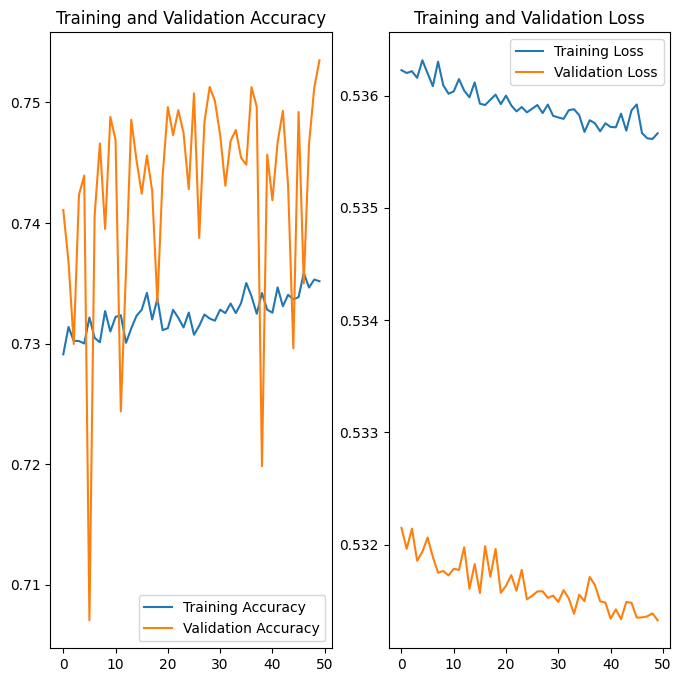

In [93]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()